/home/janik.fechtelpeter/.conda/envs/reallaborai4u/lib/python3.10/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 195, but rank is 5
  warnings.warn('covariance of constraints does not have full '
/home/janik.fechtelpeter/.conda/envs/reallaborai4u/lib/python3.10/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/janik.fechtelpeter/.conda/envs/reallaborai4u/lib/python3.10/site-packages/statsmodels/base/model.py:1917: RuntimeWarning: invalid value encountered in scalar divide
  F /= J
/home/janik.fechtelpeter/.conda/envs/reallaborai4u/lib/python3.10/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10920, but rank is 1219
  warnings.wa

ANOVA for mae
                                                    sum_sq       df         F  \
C(valid_training_data_points)                   270.020620    195.0  5.562866   
C(participant)                                         NaN     56.0       NaN   
C(valid_training_data_points):C(participant)  19166.311140  10920.0  7.051024   
Residual                                       4365.349404  17537.0       NaN   

                                               PR(>F)  
C(valid_training_data_points)                 0.00004  
C(participant)                                    NaN  
C(valid_training_data_points):C(participant)  0.00000  
Residual                                          NaN  
ANOVA for diff_mae
                                                    sum_sq       df  \
C(valid_training_data_points)                     0.000033    195.0   
C(participant)                                         NaN     56.0   
C(valid_training_data_points):C(participant)  23030.167166  10920.0 

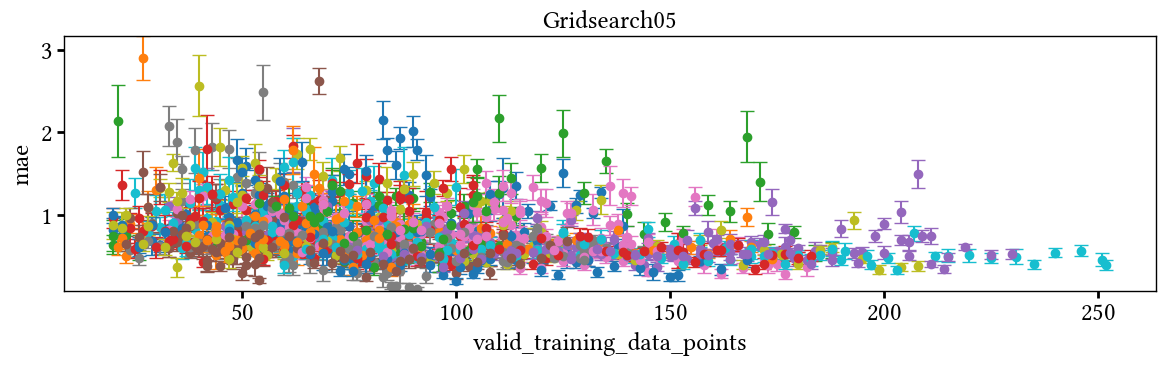

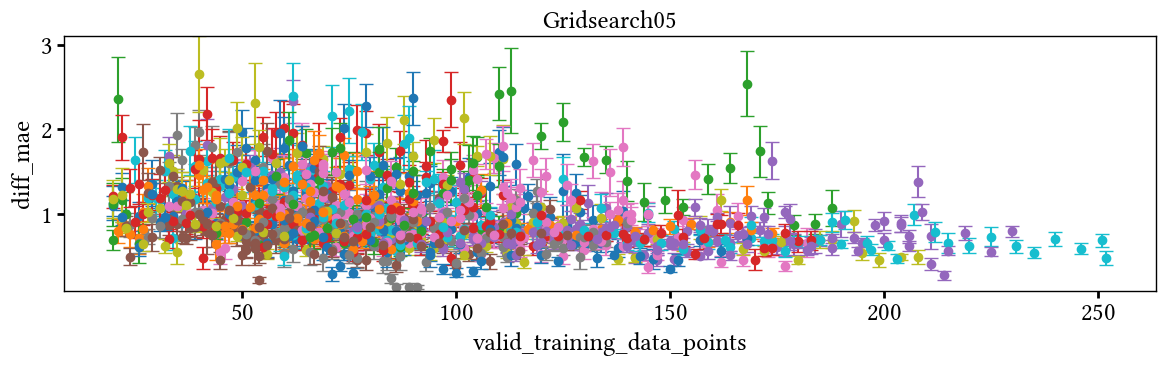

In [13]:
''' 
    Get just the evaluation plot you want. Plots a metric mean (with standard error)
    across all models that fulfil a desired combination of hyperparameters.
    x_axis:     Hyperparameter to plot on the x-axis
    curves:     String or List of hyperparameters to plot as different curves
    include_hyper: Dict with entries hyperparameter:value, only models that have this
                    hyperparameter-value combination will be included in the plot
    exclude_hyper: Dict with entries hyperparameter:value, models that have this
                    hyperparameter-value combination will be excluded from the plot
    horizontal_bar: Float or None. If float, a horizontal bar at this value will be drawn into the plot
    legend_labels: List of labels for the legend. If empty, the column names from results.csv will be used
    legend_title: Str or None. Specifies the title of the legend.
    fig_kwargs: kwargs passed to plt.subplots()
    ax_kwargs:  kwargs passed to dataframe.plot()
'''
main_dir = r'/home/janik.fechtelpeter/Documents/bptt/results/MRT1_EveryDay02_Smoothed_best_runs'
eval_dir = '00_summary_gridsearch'
name = 'valid_points_participants'
file_formats = ['png', 'svg']
x_axis = 'valid_training_data_points'
curves = ['participant']
metrics = ['mae', 'diff_mae']
ci = 'sem'
sources_of_variance = ['feature']
include_hyper = {}#{'model':'PLRNN'}#{'participant': [15, 17, 28, 34, 35, 52, 57, 61, 62]}
exclude_hyper = {'feature': ['EMA_emotion_control', 'EMA_emotion_change']}#, 'model':'VAR (1)'}

exclude_outliers = True

fig_kwargs = {}
plot_kwargs = {'kind':'line', 
               #'ylabel':'MAE', 
               #'xlabel':'steps',
               'marker':'o', 'linestyle':'', 'title':'Gridsearch05', 'legend':False,
               'figsize':(12,4)}
color_version = None
sort_by = [x_axis]
calc_anova = True


### Calculations ###

import sys
import os
sys.path.append('..')

import matplotlib.pyplot as plt
import pandas as pd
import eval_reallabor_utils
import custom_rcparams as crc

eval_dir = os.path.join(main_dir, eval_dir)
results = pd.read_csv(os.path.join(eval_dir, 'evaluation.csv'), index_col=0)
results = eval_reallabor_utils.include_exclude_hypers(results, include_hyper, exclude_hyper)  
if exclude_outliers:
    results = results[(results['prediction'].abs()<100)]
if not isinstance(curves, list):
    curves = [curves]
# results = results[[metric, x_axis] + curves]
if calc_anova:
    anova_tables = eval_reallabor_utils.anova_metrics(results, [x_axis, *curves], metrics, sources_of_variance)
    for i, m in enumerate(metrics):
        print(f'ANOVA for {m}')
        print(anova_tables[i])
metric_values, errorbars = eval_reallabor_utils.calculate_metrics(
    results, [x_axis, *curves], metrics, sources_of_variance=sources_of_variance, ci=ci)
metric_values.sort_values(by=sort_by, inplace=True)
errorbars.sort_values(by=sort_by, inplace=True)
if len(metrics)==1:
    metrics = metrics[0]
for m in metrics:
    m_unstacked = metric_values.unstack(curves)[m]
    e_unstacked = errorbars.unstack(curves)[m]
    fig, ax = plt.subplots(1, 1, **fig_kwargs)
    default_ax_kwargs = {'yerr': e_unstacked, 'kind': 'bar', 'xlabel': x_axis, 'ylabel':str(m)}
    if x_axis=='steps':
        default_ax_kwargs['kind'] = 'line'
    for key, value in plot_kwargs.items():
        default_ax_kwargs[key] = value
    if default_ax_kwargs['kind'] == 'bar':
        default_ax_kwargs.pop('linestyle')
        default_ax_kwargs.pop('marker')
    T = range(1, len(m_unstacked)+1)
    if color_version is not None:
        default_ax_kwargs['color'] = crc.colors.item_color_codes(m_unstacked.index, version=color_version)
    m_unstacked.plot(ax=ax, **default_ax_kwargs)
    # for c in m_unstacked.columns: 
    #     ax.fill_between(T, m_unstacked[c]-e_unstacked[c], m_unstacked[c]+e_unstacked[c], alpha=0.3)

    fig.tight_layout()

    if name is not None:
        for ff in file_formats:
            fig.savefig(os.path.join(eval_dir, m+'_'+name+'.'+ff))